<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/02_nn_classification_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_circles

# 1000 samples
n_samples = 1000

# create circles

X, y = make_circles(n_samples, noise = 0.03,
                    random_state = 42)

In [2]:
X.shape

(1000, 2)

In [3]:
y.shape

(1000,)

In [4]:
print(f'First 5 X features: \n {X[:5]}')
print(f'\nFirst 5 y labels: \n {y[:5]}')

First 5 X features: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels: 
 [1 1 1 1 0]


In [5]:
# visualizing the dataset using pandas and matplotlib
import pandas as pd
dict = {'X1': X[:,0],'X2': X[:,1], 'label': y}
circles = pd.DataFrame(dict)

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
# X features (X1 and X2) has a label (y) either 0 or 1
# therefore, a binary classification

# check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


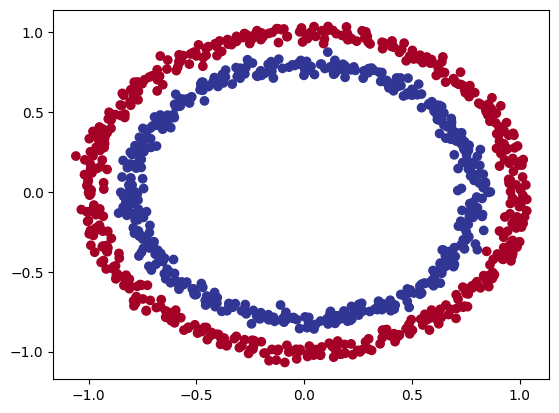

In [7]:
# visualize the plot using plt
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu   # red -- 0 ;blue --1
            );

In [8]:
# having a look over the shapes of  X and y or input and output tensor
# why?? in most of the error cases most probably the is because of shape mismatch
# it better to make sure it won't happen


# shapes
print(f'The shape of input features:\n {X.shape}')
print(f'The shape of output labels:\n {y.shape}')

The shape of input features:
 (1000, 2)
The shape of output labels:
 (1000,)


In [9]:
# so we have two inputs for 1 output(which can either be equal to 1 or 0)

# turning data into tensors

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# doing the train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
# buliding a model

from torch import nn

# devie agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [12]:
# supervised learning model -->

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)


  def forward(self,x):
    # returnt the output of l2
    return self.layer_2(self.layer_1(x)) # computation graph goes through l1 first
                                         # and then the output of l1 goes through l2

# instance creat
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# replicate the CircleModelV0 with nn Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# make predictions

untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(y_test)}, Shape{y_test.shape}')

untrained_preds[:10], y_test[:10]

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shapetorch.Size([200])


(tensor([[-0.2460],
         [-0.3229],
         [-0.3209],
         [-0.2236],
         [-0.7595],
         [-0.8030],
         [-0.6717],
         [-0.7853],
         [-0.3023],
         [-0.3329]], grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [15]:
# create a loss function
# loss_fn = nn.BCELoss()  # BCELoss---> no sigmoid bulit in
                           # BCEWithLogitsLoss = sigmoid bulit in

loss_fn = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

In [16]:
# evaluating the model
# acccuracy as a evaluation metric (or performance metric)

def accuracy_fn(y_true, y_preds):
  correct = torch.eq(y_true, y_preds).sum().item()  # torch.eq() checks for equality, element-wise
  acc = (correct/len(y_preds)) * 100
  return acc

In [17]:
# yayy----Let's start the training

# before doing training loop steps
# let's see what comes out of model during forward pass

y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2460],
        [-0.3229],
        [-0.3209],
        [-0.2236],
        [-0.7595]], grad_fn=<SliceBackward0>)

In [18]:
# outputs are random as model is not trained yet
# these numbers are nothing but the output of our forward() method

# these number doesn't make any sense
# we use sigmoid activtion function to make them meaningful and comparable


In [19]:
# use sigmoid on model logits

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4388],
        [0.4200],
        [0.4205],
        [0.4443],
        [0.3188]], grad_fn=<SigmoidBackward0>)

In [20]:
# what this means to us

# if y_pred_prob >= 0.5 => y=1 (class 1)
# if y_pred_prob < 0.5 => y=0 (class 0)

# to turn our predictions probas into labels, we can round off
# let's do

In [21]:
# for above predicts labels probabs
y_preds = torch.round(y_pred_probs)
print(f'y_preds is {y_preds}')
print(f' y_preds.squeeze is {y_preds.squeeze()}')

# in full( all the previous steps in one step)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))
print(f'y_pred_lables is {y_pred_labels}')
print(f' y_pred_labels.squeeze {y_pred_labels.squeeze()}')

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid for extra dim
y_preds.squeeze()

y_preds is tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)
 y_preds.squeeze is tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
y_pred_lables is tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)
 y_pred_labels.squeeze tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [22]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [23]:
# now let's recap what we have done
# so to compare model's predictions with the test labels ---> why?? to check performance of the model

# here, we converted model's raw inputs(logits) to predictions probas using sigmoid
# and then it to predictions labels by rounding off


In [24]:
# also, for binary classification logits ---> sigmoid function
# for multi-class classificaton --> softmax function

In [45]:
# ---TRAINING AND TESTING LOOP---


torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # TRAINING
  model_0.train()

  #forward pass
  y_logits = model_0(X_train).squeeze()     # squeeze to remove the extra '1' dim
  y_pred = torch.round(torch.sigmoid(y_logits))

  # loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)    # Using nn.BCELoss you need torch.sigmoid

  loss = loss_fn(y_logits, y_train)   # Using nn.BCEWithLogitsLoss only raw logits

  acc = accuracy_fn(y_true = y_train,
                    y_preds = y_pred)

  # optimizer
  optimizer.zero_grad()

  #loss backwards
  loss.backward()

  #optimizer step
  optimizer.step()

  #TESTING
  model_0.eval()

  with torch.inference_mode():
    # forward loss
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_preds= test_pred)


  if epoch % 10 == 0:
    print(f'Epoch: {epoch} || Loss: {loss:.5f}, Accuracy: {acc:.2f}%, || Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 10 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 20 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 30 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 40 || Loss: 0.69298, Accuracy: 51.38%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 50 || Loss: 0.69298, Accuracy: 51.38%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 60 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 70 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 80 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%
Epoch: 90 || Loss: 0.69298, Accuracy: 51.25%, || Test loss: 0.69464, Test acc: 46.00%


In [41]:
# the prediction is like random guessing as the accuracy barely moves above ~50%
# let's explore the data


# plt decision boundary
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
   # put on cpu
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # defining range of plot on x and y axes
    # =/- 0.1 to leave a little padding for the plot

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    # creates a grid of points b/w max and min values
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    # returns two 2D arrays

    # ravel() --> unravel(or flatten the 2 array)
    # column_stack --> stackes 1d array as columns in 2d

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()



    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)


    y_pred = torch.round(torch.sigmoid(y_logits))

    # reshape --> to aligns with xx, yy
    y_pred = y_pred.reshape(xx.shape).detach().numpy()


    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)

    # superimpose inital data scatter plot on top of contour plot
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

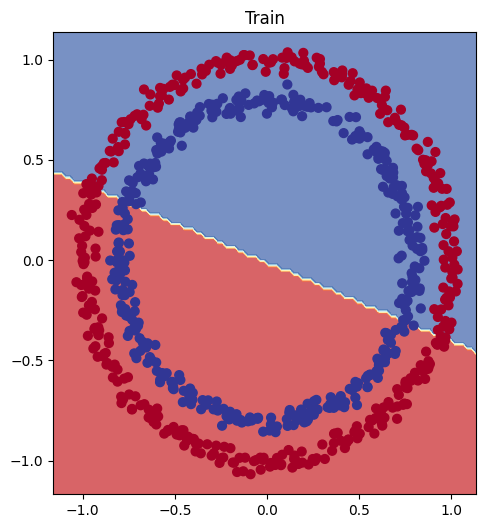

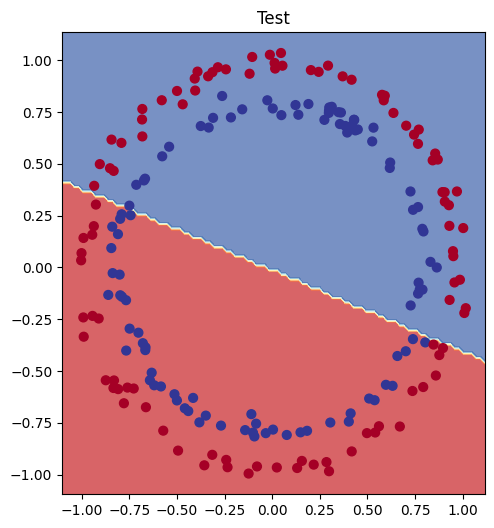

In [46]:
# plot decision boundaries

plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


In [39]:
# -- what's the problem
# actually our model is trying to split the red or blue dots using a straight line

# => model is underfitting (high loss on training as well as testing set)

How can we improve model performance

* add more layers(or hidden layers)
* more epochs
* List item
* non-linear activations
* learning-rate
* changing the loss fn
* using tranfer learning

> we can adjust all these by hand --> called hyperparameters










we tried increasing the epochs but still found that there is not much change model's performance

also, our model is pretty decent in predicting linear linear data
the problem is non-linearity in model.
we have used linear activation function while training of the model


 Let's bulid a model with non-linearity from starting

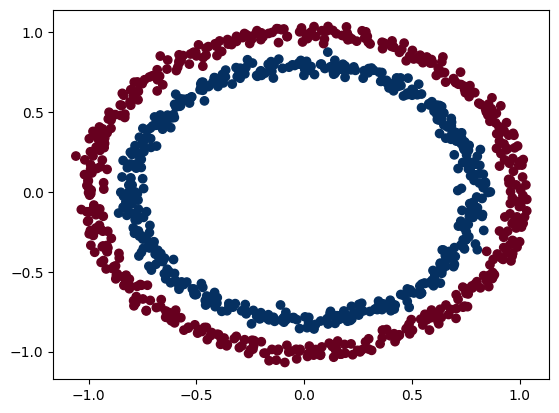

In [47]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples= 1000,
                   noise = 0.03,
                   random_state = 42)

plt.scatter(X[:,0], X[:,1], c= y, cmap = plt.cm.RdBu)

In [48]:
# spltting and conversion to tensors

import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

let's introduce non-linearity in our model by using non-linear activation functions like ReLU in this case

`ReLu = max(0,x)`

In [60]:
from torch import nn
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

    # intersperse relu b/w layers
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

Where to put relu layer?

*in b/w hidden layers and just after output layer*

In [61]:
# loss and optimizer function

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [62]:
# training and testing loop

torch.manual_seed(42)
epochs = 1000

# put data on target device
ls = [X_train, y_train, X_test, y_test]
for data in ls:
  data = data.to(device)

for epoch in range(epochs):
  # ---TRAINING---

  # forward pass  logits --> predictions probas --> prediction labels
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss n accuracy
  loss = loss_fn(y_logits, y_train)  # why not y_pred --> BCEWithLogitsLoss calculates loss using logits

  acc = accuracy_fn(y_true=y_train, y_preds= y_pred)

  # optimizer
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  # ---TESTING---

  # put model on evaluation mode
  model_2.eval()

  with torch.inference_mode():

    # forward pass
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # loss n accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_preds= test_pred)

  if epoch % 100 ==0:
    print(f'Epoch: {epoch} \n Loss: {loss:.5f}, Accuracy: {acc:.2f} \n | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}% ')



Epoch: 0 
 Loss: 0.69295, Accuracy: 50.00 
 | Test Loss: 0.69319, Test Accuracy: 50.00% 
Epoch: 100 
 Loss: 0.69115, Accuracy: 52.88 
 | Test Loss: 0.69102, Test Accuracy: 52.50% 
Epoch: 200 
 Loss: 0.68977, Accuracy: 53.37 
 | Test Loss: 0.68940, Test Accuracy: 55.00% 
Epoch: 300 
 Loss: 0.68795, Accuracy: 53.00 
 | Test Loss: 0.68723, Test Accuracy: 56.00% 
Epoch: 400 
 Loss: 0.68517, Accuracy: 52.75 
 | Test Loss: 0.68411, Test Accuracy: 56.50% 
Epoch: 500 
 Loss: 0.68102, Accuracy: 52.75 
 | Test Loss: 0.67941, Test Accuracy: 56.50% 
Epoch: 600 
 Loss: 0.67515, Accuracy: 54.50 
 | Test Loss: 0.67285, Test Accuracy: 56.00% 
Epoch: 700 
 Loss: 0.66659, Accuracy: 58.38 
 | Test Loss: 0.66322, Test Accuracy: 59.00% 
Epoch: 800 
 Loss: 0.65160, Accuracy: 64.00 
 | Test Loss: 0.64757, Test Accuracy: 67.50% 
Epoch: 900 
 Loss: 0.62362, Accuracy: 74.00 
 | Test Loss: 0.62145, Test Accuracy: 79.00% 


In [63]:
# make predictions

model_2.eval()
with torch.inference_mode():
  y_logits = model_2(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

y_pred[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

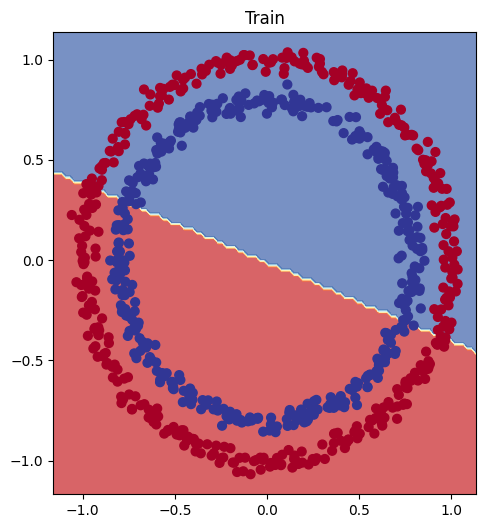

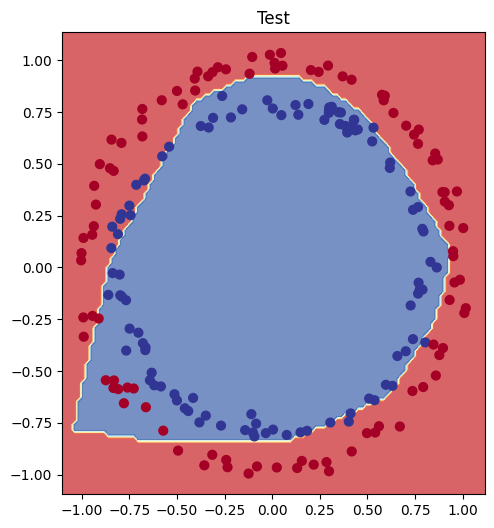

In [65]:
# plot decision boundaries

plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)

plt.figure(figsize= (12,6))
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)

not perfect, but pretty good
we can improve the model ny the ways stated above